In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
from scipy.io import loadmat
import numpy as np

# Dosyaların yolları
data_path_salinas = "/content/drive/MyDrive/proje2/datasets/salinas/Salinas_corrected.mat"
gt_path_salinas   = "/content/drive/MyDrive/proje2/datasets/salinas/Salinas_gt.mat"

data_path_paviaU = "/content/drive/MyDrive/proje2/datasets/paviaU/PaviaU.mat"
gt_path_paviaU = "/content/drive/MyDrive/proje2/datasets/paviaU/PaviaU_gt.mat"

data_path_indian = "/content/drive/MyDrive/proje2/datasets/indianpines/Indian_pines_corrected.mat"
gt_path_indian = "/content/drive/MyDrive/proje2/datasets/indianpines/Indian_pines_gt.mat"

data_path_houston = "/content/drive/MyDrive/proje2/datasets/houston/data.mat"
gt_path_houston = "/content/drive/MyDrive/proje2/datasets/houston/mask_train.mat"

# Verileri yükleme
data_salinas = loadmat(data_path_salinas)['salinas_corrected']
gt_salinas   = loadmat(gt_path_salinas)['salinas_gt']

data_paviaU = loadmat(data_path_paviaU)['paviaU']
gt_paviaU   = loadmat(gt_path_paviaU)['paviaU_gt']

data_indian = loadmat(data_path_indian)['indian_pines_corrected']
gt_indian   = loadmat(gt_path_indian)['indian_pines_gt']

data_houston = loadmat(data_path_houston)['data']
gt_houston   = loadmat(gt_path_houston)['mask_train']


# Kullanılacak dataset belirleniyor
data = data_salinas
gt   = gt_salinas

#print("Data shape:", data.shape) # (512, 217, 204)
#print("GT shape:", gt.shape)     # (512, 217)


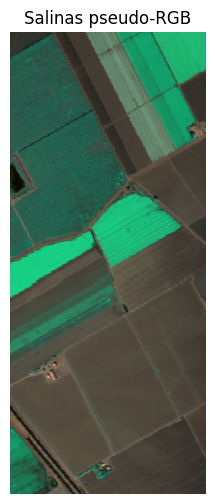

In [30]:
#VERİLERİ GÖRSELEŞTİRME (RGB İLE İLK 3 BANT)

import matplotlib.pyplot as plt

# Basit RGB benzeri görüntü (örnek olarak bant 30, 50, 70)
rgb = np.stack([data[:,:,30], data[:,:,50], data[:,:,70]], axis=2)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize et

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Salinas pseudo-RGB")
plt.axis('off')
plt.show()

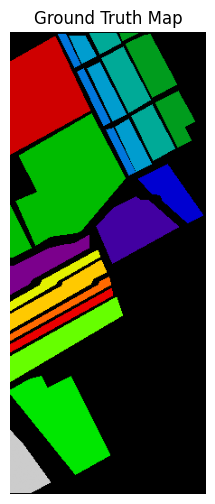

In [31]:
#ETIKET HARITASI

plt.figure(figsize=(6,6))
plt.imshow(gt, cmap='nipy_spectral')
plt.title("Ground Truth Map")
plt.axis('off')
plt.show()

In [32]:
from sklearn.decomposition import PCA

def applyMNF(data, n_components):
  # HSI verisini 2D hale getir
  h, w, b = data.shape
  data_2d = data.reshape(-1, b)  # (512*217, 204)

  # PCA ile MNF benzeri azaltma (ilk 10 bileşeni alıyoruz)
  pca = PCA(n_components=n_components)
  data_mnf = pca.fit_transform(data_2d)

  # 3D formata geri getir
  data_mnf_3d = data_mnf.reshape(h, w, -1)

  return data_mnf_3d

In [33]:
n_components = 10
mnf_data = applyMNF(data, n_components)
print("MNF Data shape:", mnf_data.shape)

MNF Data shape: (512, 217, 10)


In [34]:
# Geçerli (sınıflı) pikselleri seç
mask = gt > 0
X = mnf_data[mask]    # Özellikler
y = gt[mask]          # Etiketler

num_classes = len(np.unique(y))

print(num_classes)
print(X.shape)
print(y.shape)

16
(54129, 10)
(54129,)


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42, stratify=y)

In [36]:
# SVM eğitimi
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

svm = SVC(kernel='rbf', C=100, gamma='scale')
svm.fit(X_train, y_train)

# Tahmin
y_pred = svm.predict(X_test)

# Performans ölçütleri
svm_oa = accuracy_score(y_test, y_pred)*100
svm_kappa = cohen_kappa_score(y_test, y_pred)*100

# AA hesaplama
cm = confusion_matrix(y_test, y_pred)  # Confusion matrix
class_acc = cm.diagonal() / cm.sum(axis=1)  # Her sınıf doğruluk
svm_aa = np.mean(class_acc)*100  # Ortalama

print(f"SVM Spektral -> OA: {svm_oa:.2f}%, AA: {svm_aa:.2f}%, Kappa: {svm_kappa:.2f}%")


SVM Spektral -> OA: 91.20%, AA: 94.67%, Kappa: 90.18%


In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Pencere boyutu ve padding hesaplama
window_size = 5
pad = window_size // 2  # 5//2 = 2

# MNF verisini normalize et
h, w, c = mnf_data.shape
mnf_2d = mnf_data.reshape(-1, c)
scaler = StandardScaler()
mnf_normalized = scaler.fit_transform(mnf_2d).reshape(h, w, c)

# MNF verisini padding ile genişlet
# reflect mode: kenarları aynalayarak genişletir
mnf_padded = np.pad(mnf_normalized, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
print(f"Original shape: {mnf_normalized.shape}")
print(f"Padded shape: {mnf_padded.shape}")  # (512+4, 217+4, 10) = (516, 221, 10)

# Her piksel için 5×5 pencere oluştur
def create_patches(data_padded, gt, window_size):
    h, w = gt.shape  # Orijinal boyutlar
    pad = window_size // 2
    patches = []
    labels = []

    for i in range(h):
        for j in range(w):
            if gt[i, j] > 0:  # Sadece etiketli pikseller
                # Padded veriden pencere al
                patch = data_padded[i:i+window_size, j:j+window_size, :]
                patches.append(patch)
                labels.append(gt[i, j])

    return np.array(patches), np.array(labels)

print("\nPencereler oluşturuluyor...")
X_patches, y_patches = create_patches(mnf_padded, gt, window_size)
print(f"Patches shape: {X_patches.shape}")  # (num_samples, 5, 5, 10)
print(f"Labels shape: {y_patches.shape}")

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_patches, y_patches, test_size=0.95, random_state=42, stratify=y_patches
)

# Etiketleri 0'dan başlat (keras için)
y_train_cnn = y_train_cnn - 1
y_test_cnn = y_test_cnn - 1

print(f"Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")

# CNN Modeli
model = keras.Sequential([
    # Layer 1
    layers.Conv2D(32, (2, 2), strides=1, padding='same',
                  input_shape=(window_size, window_size, n_components)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Layer 2
    layers.Conv2D(16, (2, 2), strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Flatten ve Classification
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Model derleme
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model eğitimi
print("\nCNN eğitiliyor...")
history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=128,
    epochs=100,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Test
y_pred_cnn = model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Performans metrikleri
cnn_oa = accuracy_score(y_test_cnn, y_pred_cnn) * 100
cnn_kappa = cohen_kappa_score(y_test_cnn, y_pred_cnn) * 100

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
class_acc_cnn = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
cnn_aa = np.mean(class_acc_cnn) * 100

print(f"\n{'='*60}")
print(f"CNN Spektral -> OA: {cnn_oa:.2f}%, AA: {cnn_aa:.2f}%, Kappa: {cnn_kappa:.2f}%")
print(f"{'='*60}")

Original shape: (512, 217, 10)
Padded shape: (516, 221, 10)

Pencereler oluşturuluyor...
Patches shape: (54129, 5, 5, 10)
Labels shape: (54129,)
Train: (2706, 5, 5, 10), Test: (51423, 5, 5, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,984 (39.00 KB)

 Trainable params: 9,888 (38.62 KB)

 Non-trainable params: 96 (384.00 B)


CNN eğitiliyor...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.3094 - loss: 2.2385 - val_accuracy: 0.7438 - val_loss: 0.6764 - learning_rate: 0.0100
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7362 - loss: 0.6441 - val_accuracy: 0.8744 - val_loss: 0.3820 - learning_rate: 0.0100
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8748 - loss: 0.3768 - val_accuracy: 0.9187 - val_loss: 0.2897 - learning_rate: 0.0100
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8895 - loss: 0.3235 - val_accuracy: 0.9335 - val_loss: 0.2505 - learning_rate: 0.0100
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8937 - loss: 0.3002 - val_accuracy: 0.9335 - val_loss: 0.2369 - learning_rate: 0.0100
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9126 - loss: 0.2600 - val_accuracy: 0.9335 - val_loss: 0.2107 - learning_rate: 0.0100
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.928


[6/6] Comparison and Visualization
Method          OA           AA           Kappa        Improvement
----------------------------------------------------------------------
SVM             76.59        76.74        74.92        baseline
CNN             75.47        75.51        73.72        +-1.11%

Key Finding (from paper):
'CNN outperforms traditional spectral-based SVM by ~6% on average'
'This proves that spatial characteristics in CNN play an important role'


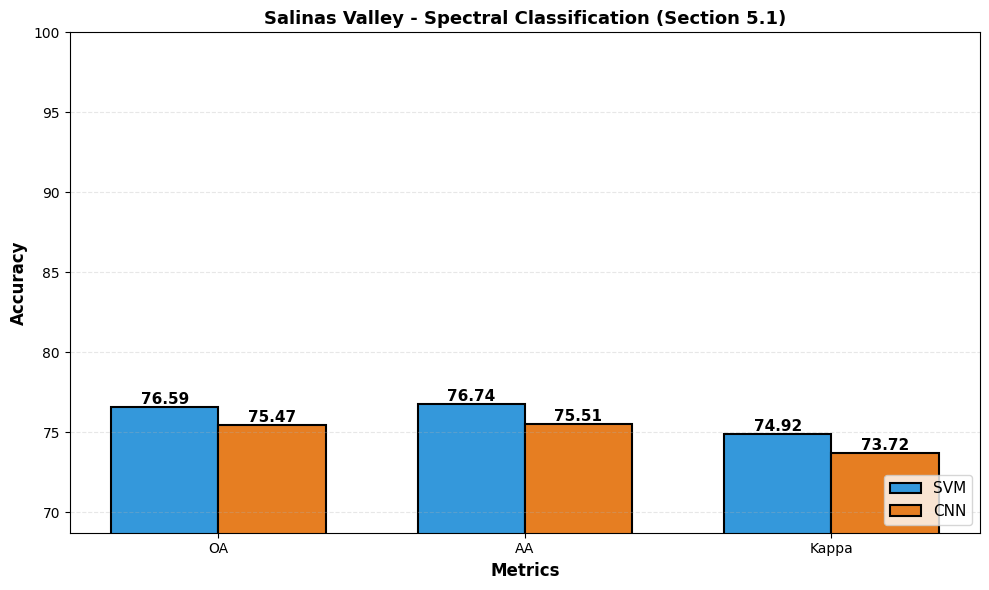


Results saved as 'salinas_spectral_classification.png'


In [15]:
# ==================== KARŞILAŞTIRMA ====================
print("\n[6/6] Comparison and Visualization")
print("="*70)
print(f"{'Method':<15} {'OA':<12} {'AA':<12} {'Kappa':<12} {'Improvement'}")
print("-"*70)
print(f"{'SVM':<15} {svm_oa:<12.2f} {svm_aa:<12.2f} {svm_kappa:<12.2f} {'baseline'}")
print(f"{'CNN':<15} {cnn_oa:<12.2f} {cnn_aa:<12.2f} {cnn_kappa:<12.2f} {f'+{cnn_oa-svm_oa:.2f}%'}")
print("="*70)

print(f"\nKey Finding (from paper):")
print(f"'CNN outperforms traditional spectral-based SVM by ~6% on average'")
print(f"'This proves that spatial characteristics in CNN play an important role'")

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['OA', 'AA', 'Kappa']
svm_values = [svm_oa, svm_aa, svm_kappa]
cnn_values = [cnn_oa, cnn_aa, cnn_kappa]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, svm_values, width, label='SVM',
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, cnn_values, width, label='CNN',
               color='#e67e22', edgecolor='black', linewidth=1.5)

# Değerleri ekle
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Salinas Valley - Spectral Classification (Section 5.1)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([min(min(svm_values), min(cnn_values))-5, 100])
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('salinas_spectral_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nResults saved as 'salinas_spectral_classification.png'")